# Optimizing Sleep Spindle Detection with Machine Learning
Author: Manuel Romanelli, Matteo Vairani & Gabriel Tabacaru

This Jupyter notebook documents the development and evaluation of a personalized sleep spindle detection algorithm, building upon the methodologies proposed in the paper titled "Personalized Sleep Spindle Detection in Whole Night Polysomnography". Our objective is to understand, reproduce, and enhance the detection capabilities reported in the study using advanced machine learning techniques and feature engineering. Through this notebook, we explore various classifiers and feature selection processes to improve the sensitivity and specificity of spindle detection in EEG signals.

Sources:
https://zenodo.org/records/2650142#.ZDkhp3ZBw2w

## Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm
import nolds
import joblib
import xgboost as xgb

In [2]:
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert, welch, spectrogram
from scipy import stats

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression

In [4]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

## Dataset Import
Loading the EEG signals of the patients

In [5]:
RED_COLOR = "\033[91m"
RESET_COLOR = "\033[0m"

datasets_edf_path = [
    "dataset/excerpt1.edf",
    "dataset/excerpt2.edf",
    "dataset/excerpt3.edf",
    "dataset/excerpt4.edf",
    "dataset/excerpt5.edf",
    "dataset/excerpt6.edf",
    "dataset/excerpt7.edf",
    "dataset/excerpt8.edf"
]
datasets = []
for file_path in datasets_edf_path:
    try:
        raw = mne.io.read_raw_edf(file_path, preload=True)
    except Exception as e:
        print(f'{RED_COLOR}file: {file_path} has faced an error: {e}{RESET_COLOR}')
        continue
    datasets.append(raw)

Extracting EDF parameters from c:\Users\matte\OneDrive\Desktop\SCHOOL\2023 - 2024\spring_semester\subjects\key_areas_far\project\dataset\excerpt1.edf...
EDF file detected
file: dataset/excerpt1.edf has faced an error: not enough values to unpack (expected 3, got 2)
Extracting EDF parameters from c:\Users\matte\OneDrive\Desktop\SCHOOL\2023 - 2024\spring_semester\subjects\key_areas_far\project\dataset\excerpt2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Scaling factor is not defined in following channels:
event_pneumo, event_pneumo_aut
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Physical range is not defined in following channels:
VAB, NAF2P-A1, PCPAP, POS, FP2-A1, O2-A1, CZ2-A1, event_pneumo, event_pneumo_aut
  raw = mne.io.read_raw_edf(file_path, preload=True)


Reading 0 ... 359999  =      0.000 ...  1799.995 secs...
Extracting EDF parameters from c:\Users\matte\OneDrive\Desktop\SCHOOL\2023 - 2024\spring_semester\subjects\key_areas_far\project\dataset\excerpt3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 89999  =      0.000 ...  1799.980 secs...
Extracting EDF parameters from c:\Users\matte\OneDrive\Desktop\SCHOOL\2023 - 2024\spring_semester\subjects\key_areas_far\project\dataset\excerpt4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359999  =      0.000 ...  1799.995 secs...


C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Scaling factor is not defined in following channels:
event_pneumo_aut
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Physical range is not defined in following channels:
PCPAP, event_pneumo_aut
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from c:\Users\matte\OneDrive\Desktop\SCHOOL\2023 - 2024\spring_semester\subjects\key_areas_far\project\dataset\excerpt5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359999  =      0.000 ...  1799.995 secs...
Extracting EDF parameters from c:\Users\matte\OneDrive\Desktop\SCHOOL\2023 - 2024\spring_semester\subjects\key_areas_far\project\dataset\excerpt6.edf...


C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Physical range is not defined in following channels:
PCPAP
  raw = mne.io.read_raw_edf(file_path, preload=True)


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359999  =      0.000 ...  1799.995 secs...


C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Scaling factor is not defined in following channels:
event_pneumo_aut
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Physical range is not defined in following channels:
VTH, VAB, NAF2P-A1, NAF1, PCPAP, FP2-A1, O2-A1, CZ2-A1, event_pneumo_aut
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from c:\Users\matte\OneDrive\Desktop\SCHOOL\2023 - 2024\spring_semester\subjects\key_areas_far\project\dataset\excerpt7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359999  =      0.000 ...  1799.995 secs...
Extracting EDF parameters from c:\Users\matte\OneDrive\Desktop\SCHOOL\2023 - 2024\spring_semester\subjects\key_areas_far\project\dataset\excerpt8.edf...
EDF file detected


C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Scaling factor is not defined in following channels:
PHONO
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Physical range is not defined in following channels:
PHONO, PCPAP, POS, FP2-A1, O2-A1
  raw = mne.io.read_raw_edf(file_path, preload=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359999  =      0.000 ...  1799.995 secs...


C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Scaling factor is not defined in following channels:
event_pneumo, event_pneumo_aut
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1480268753.py:17: RuntimeWarning: Physical range is not defined in following channels:
NAF2P-A1, NAF1, PHONO, PCPAP, POS, event_pneumo, event_pneumo_aut
  raw = mne.io.read_raw_edf(file_path, preload=True)


For some reasons the first file rise an exception. After some trials we decided to quit the trials for solving this problem and continue the analysis with only the other 7 edf datasets and load the txt file for the excerpt1.

In [6]:
exc1 = pd.read_csv('dataset/excerpt1.txt')
exc1.rename(columns={'[C3-A1]':'EEG_Signal'},inplace=True)
exc1

,EEG_Signal
0,-0.9562
1,-0.8962
2,-3.1877
3,-4.1783
4,-5.3190
...,...
179995,-35.3882
179996,-36.7090
179997,-29.3243
179998,-21.6895


## Signal Resempling

We are managing time series data by assigning timestamps to EEG signals and adjusting their sampling resolution. It starts by creating a time index at a 10ms interval, setting it to the DataFrame, then resamples the data to a finer 5ms interval using linear interpolation to enhance temporal detail, crucial for precise analysis in machine learning tasks related to EEG.

In [7]:
timestamps = pd.date_range(start='2024-05-01', periods=len(exc1), freq='10ms')
exc1['Timestamp'] = timestamps
exc1.set_index('Timestamp', inplace=True)
exc1_resampled = exc1.resample('5ms').interpolate(method='linear')
exc1_resampled.reset_index(inplace=True)
exc1_resampled['Timestamp'] = [t.strftime('%H:%M:%S.%f') for t in exc1_resampled['Timestamp']]

exc1_resampled

,Timestamp,EEG_Signal
0,00:00:00.000000,-0.95620
1,00:00:00.005000,-0.92620
2,00:00:00.010000,-0.89620
3,00:00:00.015000,-2.04195
4,00:00:00.020000,-3.18770
...,...,...
359994,00:29:59.970000,-29.32430
359995,00:29:59.975000,-25.50690
359996,00:29:59.980000,-21.68950
359997,00:29:59.985000,-17.26165


In [8]:
for i in datasets:
    i.resample(200,npad='auto')

Sampling frequency of the instance is already 200.0, returning unmodified.
Sampling frequency of the instance is already 200.0, returning unmodified.
Sampling frequency of the instance is already 200.0, returning unmodified.
Sampling frequency of the instance is already 200.0, returning unmodified.
Sampling frequency of the instance is already 200.0, returning unmodified.
Sampling frequency of the instance is already 200.0, returning unmodified.


In [9]:
for i in datasets:
    print('The channels are:', i.ch_names)
    print('The sampling frequency is:', i.info['sfreq'])

The channels are: ['ECG', 'FP1-A1', 'CZ-A1', 'EMG1', 'EOG1-A1', 'VTH', 'VAB', 'NAF2P-A1', 'NAF1', 'PHONO', 'PR', 'SAO2', 'PCPAP', 'POS', 'EOG2-A1', 'O1-A1', 'FP2-A1', 'O2-A1', 'CZ2-A1', 'EMG2', 'PULSE', 'VTOT', 'EMG3', 'hypnogram', 'event_pneumo', 'hypnogram_aut', 'event_pneumo_aut', 'event_neuro']
The sampling frequency is: 200.0
The channels are: ['O1-A1', 'EMG1', 'ECG', 'NAF1', 'VAB', 'VTH', 'C3-A1', 'FP1-A1', 'EOG2-A1', 'EOG1-A1', 'POS', 'PHONO', 'SAO2', 'PR', 'PULSE', 'hypnogram', 'event_pneumo', 'hypnogram_aut', 'event_pneumo_aut', 'event_neuro']
The sampling frequency is: 200.0
The channels are: ['ECG', 'FP1-A1', 'CZ-A1', 'EMG1', 'EOG1-A1', 'VTH', 'VAB', 'NAF2P-A1', 'NAF1', 'PHONO', 'PR', 'SAO2', 'PCPAP', 'POS', 'EOG2-A1', 'O1-A1', 'FP2-A1', 'O2-A1', 'CZ2-A1', 'EMG2', 'PULSE', 'VTOT', 'EMG3', 'hypnogram', 'event_pneumo', 'hypnogram_aut', 'event_pneumo_aut', 'event_neuro']
The sampling frequency is: 200.0
The channels are: ['ECG', 'FP1-A1', 'CZ-A1', 'EMG1', 'EOG1-A1', 'VTH', 'VAB

In [10]:
datasets[0].describe()

<RawEDF | excerpt2.edf, 28 x 360000 (1800.0 s), ~76.9 MB, data loaded>
ch  name              type  unit        min         Q1     median         Q3        max
 0  ECG               EEG   µV    -156000000.00  -6546370.97  -1325545.54  10896386.78  96989998.42
 1  FP1-A1            EEG   µV    -327660000.00  -14980000.00  350000.00  15770000.00  261000000.00
 2  CZ-A1             EEG   µV    -328133058.18  -15044901.08  -21150.65  14952587.28  284989997.50
 3  EMG1              EEG   µV    -78990007.07  -755324.52  -155748.46  433834.66  118990007.07
 4  EOG1-A1           EEG   µV    -328036398.18  -8192390.38  -462776.86  8006799.66  327280835.96
 5  VTH               EEG   µV    -1000000.00  -39647.58   22026.43   83700.44  991189.43
 6  VAB               EEG   µV         0.00  375000.00  412500.00  450000.00  987500.00
 7  NAF2P-A1          EEG   µV     18518.52  740740.74  740740.74  740740.74  981481.48
 8  NAF1              EEG   µV    -989436.62   98591.55  246478.87  362676.06  1

To avoid two different format of the data during the analysis we converted all of them into a pandas dataframe.

In [11]:
annotated_channels = ['CZ-A1', 'C3-A1', 'CZ-A1', 'CZ-A1', 'CZ-A1', 'CZ-A1', 'CZ-A1']
dfs = []
dfs.append(exc1_resampled)
for i in range(len(datasets)):
    eeg_signal = datasets[i][annotated_channels[i]][0].flatten()
    timestamps = datasets[i][annotated_channels[i]][1]
    dfs.append(pd.DataFrame({'EEG_Signal': eeg_signal, 'Timestamp': timestamps}))
dfs[1]

,EEG_Signal,Timestamp
0,-1.831603,0.000
1,-4.192192,0.005
2,-5.932626,0.010
3,-7.593041,0.015
4,-8.173186,0.020
...,...,...
359995,-0.111173,1799.975
359996,-1.571538,1799.980
359997,-1.991643,1799.985
359998,-0.931378,1799.990


In [12]:
dfs[0]['Timestamp']=dfs[1]['Timestamp']

In [13]:
dfs[1]['EEG_Signal'].describe()

count    360000.000000
mean         -0.370154
std          29.247577
min        -328.133058
25%         -15.044901
50%          -0.021151
75%          14.952587
max         284.989998
Name: EEG_Signal, dtype: float64

## Filter Applicaton
Segmenting applies a Butterworth bandpass filter with specific low and high frequency limits to EEG signals in a dataset, effectively isolating the frequency components between 0.3 and 35 Hz for focused analysis, and stores the filtered signals in a new DataFrame.

The `butter_bandpass` function creates a Butterworth bandpass filter, crucial for isolating specific EEG frequency bands by setting lower and upper frequency limits and the filter's order.

In [14]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

The `butter_bandpass_filter` function applies a Butterworth bandpass filter to data, using specified cutoff frequencies and filter order to remove unwanted frequencies and enhance signal analysis.

In [15]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [16]:
lowcut = 0.3  
highcut = 35 
fs = 200   
filtered_dfs = []   

for i in dfs:
    filtered_signal = butter_bandpass_filter(i['EEG_Signal'], lowcut, highcut, fs)
    filtered_dfs.append(pd.DataFrame({'EEG_Signal': filtered_signal, 'Timestamp': i['Timestamp']}))
    
filtered_dfs[0].head()

,EEG_Signal,Timestamp
0,0.531791,0.000
1,0.536231,0.005
2,0.222541,0.010
3,-0.499366,0.015
4,-1.455266,0.020


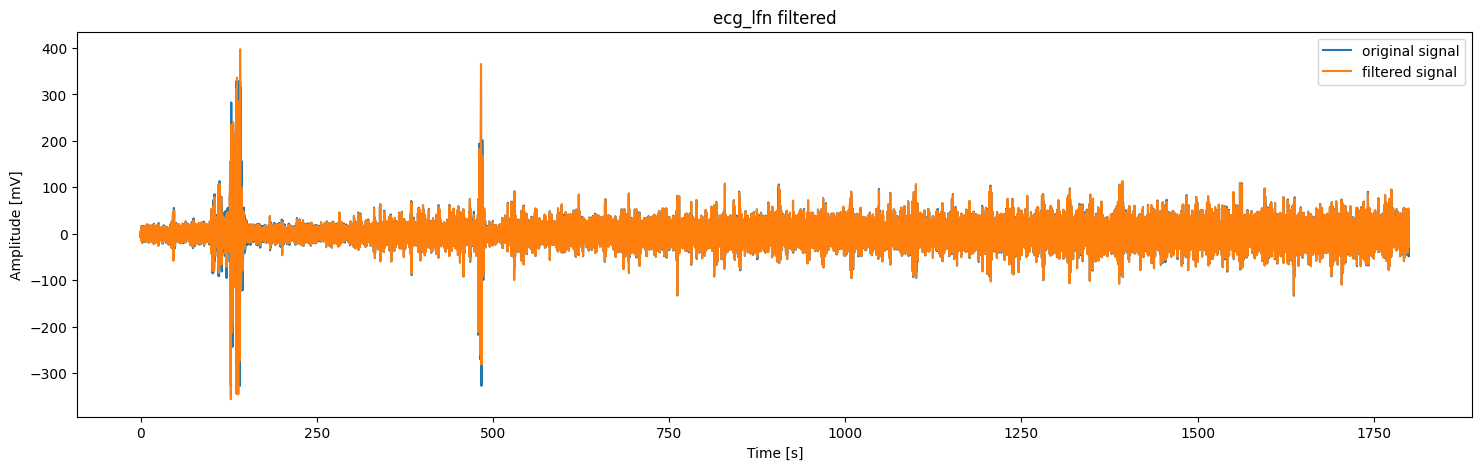

In [17]:
plt.figure(figsize=(18,5))
plt.plot(dfs[0]['Timestamp'], dfs[0]['EEG_Signal'], label = 'original signal')
plt.plot(filtered_dfs[0]['Timestamp'],filtered_dfs[0]['EEG_Signal'], label = 'filtered signal')
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.title("ecg_lfn filtered")
plt.show()

The graph displays an EEG signal before and after applying a bandpass filter, highlighting the filter's efficacy in reducing noise and enhancing signal clarity. The filtered signal (in orange) shows a significant reduction in amplitude variability compared to the original (in blue), particularly evident during high-amplitude spikes, demonstrating the filter's role in isolating relevant EEG frequencies for analysis.

## Load the visual scoring
Initializes and populates lists for visual scoring data from two sets of text files, mapping sleep spindle annotations to EEG channel data and transforming file paths for accessibility. It reads, reformats, and stores the data for further processing, crucial for aligning expert annotations with the corresponding EEG signals in sleep studies.

In [18]:
file_names_1 = [
    "Visual_scoring1_excerpt1.txt", "Visual_scoring1_excerpt2.txt", "Visual_scoring1_excerpt3.txt",
    "Visual_scoring1_excerpt4.txt", "Visual_scoring1_excerpt5.txt", "Visual_scoring1_excerpt6.txt",
    "Visual_scoring1_excerpt7.txt", "Visual_scoring1_excerpt8.txt"
]
file_names_2 = [
    "Visual_scoring2_excerpt1.txt", "Visual_scoring2_excerpt2.txt", "Visual_scoring2_excerpt3.txt", 
    "Visual_scoring2_excerpt4.txt", "Visual_scoring2_excerpt5.txt", "Visual_scoring2_excerpt6.txt"
]

file_names_1 = ['dataset/' + file_name for file_name in file_names_1]
file_names_2 = ['dataset/' + file_name for file_name in file_names_2]

annotated_channels = ['C3-A1', 'CZ-A1', 'C3-A1', 'CZ-A1', 'CZ-A1', 'CZ-A1', 'CZ-A1', 'CZ-A1']

vs1 = []
vs2 = []

for i in range(len(file_names_1)):
    vs1.append(pd.read_csv(file_names_1[i], sep='\t').reset_index().rename(columns={'index': 'beginning', f'[vis1_Spindles/{annotated_channels[i]}]': 'duration'}))
    
for i in range(len(file_names_2)):
    vs2.append(pd.read_csv(file_names_2[i], sep='\t').reset_index().rename(columns={'index': 'beginning', f'[vis2_Spindles/{annotated_channels[i]}]': 'duration'}))
    
vs1[0].head()

,beginning,duration
0,282.24,0.72
1,311.72,1.54
2,340.28,0.72
3,366.83,0.65
4,373.74,0.50


In [19]:
vs2[0].head()

,beginning,duration
0,396.56,1.0
1,422.69,1.0
2,437.38,1.0
3,440.77,1.0
4,524.98,1.0


## Load labels
Checking the existence of a specific labeled dataset file, if it exists, the datasets are loaded, if not, the datasets are generated by labeling the filtered data and then saved as CSV files, facilitating both data reuse and initial dataset creation.

The `label_epochs` function labels EEG epochs as containing a sleep spindle (1) or not (0) by checking each timestamp against spindle event timings in a dataframe, effectively creating a binary label for each epoch based on spindle presence.

In [20]:
def label_epochs(eeg_timestamp, spindle_df):
    labels = []
    for timestamp in tqdm(eeg_timestamp, desc='Labeling epochs'):
        spindle_events = spindle_df[spindle_df['beginning'] <= timestamp]
        spindle_events = spindle_events[spindle_events['beginning'] + spindle_events['duration'] >= timestamp]
        if not spindle_events.empty:
            labels.append(1)
        else:
            labels.append(0) 
    return labels

The `label_dataset` function annotates a dataset with sleep spindle presence by applying labels to each epoch across multiple recordings, enhancing the dataset with binary labels that indicate whether each epoch contains a sleep spindle, based on expert scoring.

In [21]:
def label_dataset(scoring_df,signal_df):
    ldfs = []
    for i in range(len(scoring_df)):
        labels = label_epochs(signal_df[i]['Timestamp'], scoring_df[i])
        ldf = signal_df[i].copy()
        ldf['Label'] = labels
        ldfs.append(ldf)
    return ldfs

The `load_datasets` loads a series of datasets sequentially numbered and stored as CSV files, checking for their existence and reading them into a list, thus enabling batch processing of similarly structured data files.

In [22]:
def load_datasets(file_name):
    datasets = []
    idx = 0
    while os.path.exists(f"{file_name}_{idx}.csv"):
        datasets.append(pd.read_csv(f"{file_name}_{idx}.csv"))
        idx += 1
    return datasets

In [23]:
if os.path.exists('labeled1_dataset_0.csv'):
    print("File labeled1_dataset_0.csv exists.")
    labeled1_dfs = load_datasets('labeled1_dataset')
    labeled2_dfs = load_datasets('labeled2_dataset')
else:
    print("File labeled1_dataset_0.csv does not exist.")
    labeled1_dfs = label_dataset(vs1, filtered_dfs)
    for idx, df in enumerate(labeled1_dfs):
        df.to_csv(f"labeled1_dataset_{idx}.csv", index=False)
    labeled2_dfs = label_dataset(vs2, filtered_dfs)
    for idx, df in enumerate(labeled2_dfs):
        df.to_csv(f"labeled2_dataset_{idx}.csv", index=False)

File labeled1_dataset_0.csv exists.


In [24]:
labeled1_dfs[0]

,EEG_Signal,Timestamp,Label
0,0.531805,0.000,0
1,0.536246,0.005,0
2,0.222555,0.010,0
3,-0.499351,0.015,0
4,-1.455252,0.020,0
...,...,...,...
359994,-18.837096,1799.970,0
359995,-14.980448,1799.975,0
359996,-10.988601,1799.980,0
359997,-7.131446,1799.985,0


since all the scoring from visual_scoring1 stop finding spindles after about timestamp=1000 we delete the rows after

In [25]:
for i in range(len(labeled1_dfs)):
    labeled1_dfs[i] = labeled1_dfs[i][labeled1_dfs[i]['Timestamp'] < 1000]
labeled1_dfs[0]

,EEG_Signal,Timestamp,Label
0,0.531805,0.000,0
1,0.536246,0.005,0
2,0.222555,0.010,0
3,-0.499351,0.015,0
4,-1.455252,0.020,0
...,...,...,...
199995,-10.236773,999.975,0
199996,-9.346134,999.980,0
199997,-9.203474,999.985,0
199998,-10.215466,999.990,0


## Feature Extraction & Windowing

Iteratively processing EEG data from multiple datasets using the `FeatureExtractor` class, extracting an array of features crucial for sleep spindle detection or other analyses. Each dataset is processed to compute and compile a DataFrame of features, which are stored in a list, enabling comprehensive analysis and model training.

The `FeatureExtractor` class is designed for advanced EEG data analysis. It initializes by segmenting the data into time windows and then computes a comprehensive set of features including statistical measures, spectral properties, and nonlinear dynamics for each window. This facilitates detailed characterizations of EEG signals, crucial for tasks like identifying sleep spindles or diagnosing neurological disorders.

In [26]:
class FeatureExtractor:
    def __init__(self, data, sampling_freq=200, window_size=0.5):
        self.sampling_freq = sampling_freq
        self.__windowed_data = self._window_data(data, window_size)

    def _window_data(self, data, window_size):
        windowed_data = np.array([
            data[int(window_idx * window_size * self.sampling_freq):
                 int((window_idx + 1) * window_size * self.sampling_freq)]
            for window_idx in range(len(data) // int(self.sampling_freq * window_size))
        ])
        return windowed_data

    def _sample_entropy(self):
        sample_entropies = []
        for w_data in self.__windowed_data:
            sample_entropies.append(nolds.sampen(w_data))
        return sample_entropies

    def _variance(self):
        variances = []
        for w_data in self.__windowed_data:
            variances.append(np.var(w_data))
        return variances

    def _standard_deviation(self):
        std_deviations = []
        for w_data in self.__windowed_data:
            std_deviations.append(np.std(w_data))
        return std_deviations

    def _instantaneous_frequency(self):
        inst_freq = []
        for w_data in self.__windowed_data:
            analytic_signal = hilbert(w_data)
            instantaneous_phase = np.unwrap(np.angle(analytic_signal))
            instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi)) * self.sampling_freq
            mean_inst_freq = np.mean(instantaneous_frequency)
            inst_freq.append(mean_inst_freq)
        return inst_freq

    def _pac(self):
        pac = []
        for w_data in self.__windowed_data:
            _, _, Sxx = spectrogram(w_data, fs=self.sampling_freq)
            v = np.sum(Sxx[11:17, :]) / np.sum(Sxx)
            pac.extend([v] * 8)
        return pac

    def _energy_ratio(self):
        energy_ratio = []
        for w_data in self.__windowed_data:
            total_energy = np.sum(w_data ** 2)
            spindle_energy = np.sum(w_data ** 2)
            energy_ratio.append(spindle_energy / total_energy)
        return energy_ratio

    def _peak_power(self):
        power_peak = []
        for w_data in self.__windowed_data:
            frequencies, power = welch(w_data, self.sampling_freq)
            freq_indices = np.where((frequencies >= 11) & (frequencies <= 14))
            power_peak.append(np.max(power[freq_indices]))
        return power_peak

    def _power_ratio(self):
        power_ratio = []
        for w_data in self.__windowed_data:
            frequencies, power = welch(w_data, self.sampling_freq)
            spindle_freq_indices = np.where((frequencies >= 11) & (frequencies <= 14))
            low_freq_indices = np.where((frequencies >= 0.3) & (frequencies <= 8.))
            total_power_spindle = np.sum(power[spindle_freq_indices])
            total_power_low = np.sum(power[low_freq_indices])
            power_ratio.append(total_power_spindle / total_power_low)
        return power_ratio

    def _mean_frequency(self):
        mean_freq = []
        for w_data in self.__windowed_data:
            analytic_signal = hilbert(w_data)
            instantaneous_phase = np.unwrap(np.angle(analytic_signal))
            instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi)) * self.sampling_freq
            mean_inst_freq = np.mean(instantaneous_frequency)
            mean_freq.append(mean_inst_freq)
        return mean_freq

    def _zero_crossing_rate(self):
        zcr = []
        for w_data in self.__windowed_data:
            zero_crossings = np.where(np.diff(np.sign(w_data)))[0]
            zcr.append(len(zero_crossings))
        return zcr

    def _hjorth(self):
        hjorth_params = []
        for w_data in self.__windowed_data:
            first_derivative = np.diff(w_data)
            second_derivative = np.diff(w_data, 2)
            var_zero = np.mean(w_data ** 2)
            var_d1 = np.mean(first_derivative ** 2)
            var_d2 = np.mean(second_derivative ** 2)
            mobility = np.sqrt(var_d1 / var_zero)
            complexity = np.sqrt(var_d2 / var_d1) / mobility
            hjorth_params.append((mobility, complexity))
        return hjorth_params
    
    def _mean_absolute_amplitude(self):
        mean_abs_amp = []
        for w_data in self.__windowed_data:
            mean_abs_amp.append(np.mean(np.abs(w_data)))
        return mean_abs_amp

    def _median_absolute_amplitude(self):
        median_abs_amp = []
        for w_data in self.__windowed_data:
            median_abs_amp.append(np.median(np.abs(w_data)))
        return median_abs_amp

    def _skewness_of_gradient(self):
        skew_grad = []
        for w_data in self.__windowed_data:
            gradient = np.gradient(w_data)
            skew_grad.append(stats.skew(gradient))
        return skew_grad
    
    def _kurtosis_of_gradient(self):
        kurt_grad = []
        for w_data in self.__windowed_data:
            gradient = np.gradient(w_data)
            kurt_grad.append(stats.kurtosis(gradient))
        return kurt_grad

    def _spectral_entropy(self):
        spectral_entropies = []
        for w_data in self.__windowed_data:
            _, psd = welch(w_data, self.sampling_freq)
            psd_normalized = psd / np.sum(psd)
            spectral_entropies.append(-np.sum(psd_normalized * np.log2(psd_normalized)))
        return spectral_entropies

    def _hurst_exponent(self):
        hurst_exponents = []
        for w_data in self.__windowed_data:
            hurst_exponents.append(nolds.dfa(w_data))
        return hurst_exponents

    def _signal_energy(self):
        signal_energies = []
        for w_data in self.__windowed_data:
            signal_energies.append(np.sum(w_data ** 2))
        return signal_energies

    def _crossings(self):
        crossings = []
        for w_data in self.__windowed_data:
            crossings.append(np.sum(np.diff(np.sign(w_data)) != 0))
        return crossings

    def _interquartile_range(self):
        iqrs = []
        for w_data in self.__windowed_data:
            q75, q25 = np.percentile(w_data, [75 ,25])
            iqr = q75 - q25
            iqrs.append(iqr)
        return iqrs
    
    def _mean_absolute_amplitude(self):
        mean_abs_amp = []
        for w_data in self.__windowed_data:
            mean_abs_amp.append(np.mean(np.abs(w_data)))
        return mean_abs_amp

    def _median_absolute_amplitude(self):
        median_abs_amp = []
        for w_data in self.__windowed_data:
            median_abs_amp.append(np.median(np.abs(w_data)))
        return median_abs_amp

    def extract_features(self):
        val_dict = {}
        samp_entropy = [nolds.sampen(w_data) for w_data in self.__windowed_data]
        val_dict['sample_entropy'] = samp_entropy
        max_value = [np.max(w_data) for w_data in self.__windowed_data]
        val_dict['max_value'] = max_value
        min_value = [np.min(w_data) for w_data in self.__windowed_data]
        val_dict['min_value'] = min_value
        variance = [np.var(w_data) for w_data in self.__windowed_data]
        val_dict['variance'] = variance
        std_deviation = [np.std(w_data) for w_data in self.__windowed_data]
        val_dict['std_deviation'] = std_deviation
        phase_amp_coupling = self._pac()
        if len(phase_amp_coupling) < len(std_deviation):
            phase_amp_coupling.extend([phase_amp_coupling[-1]] * (len(std_deviation) - len(phase_amp_coupling)))
        elif len(phase_amp_coupling) > len(std_deviation):
            phase_amp_coupling = phase_amp_coupling[:len(std_deviation)]
        val_dict['phase_amp_coupling'] = phase_amp_coupling
        inst_freq = self._mean_frequency()
        val_dict['mean_freq'] = inst_freq
        energy_ratio = self._energy_ratio()
        val_dict['energy_ratio'] = energy_ratio
        kurtosis_val = [stats.kurtosis(w_data) for w_data in self.__windowed_data]
        val_dict['kurtosis'] = kurtosis_val
        skewness_val = [stats.skew(w_data) for w_data in self.__windowed_data]
        val_dict['skewness'] = skewness_val
        power_peak = self._peak_power()
        val_dict['power_peak'] = power_peak
        power_ratio = self._power_ratio()
        val_dict['power_ratio'] = power_ratio
        iqr = [stats.iqr(w_data) for w_data in self.__windowed_data]
        val_dict['iqr'] = iqr
        zcr = self._zero_crossing_rate()
        val_dict['zrc'] = zcr
        hjorth_params = self._hjorth()
        mobility = [param[0] for param in hjorth_params]
        complexity = [param[1] for param in hjorth_params]
        val_dict['mobility'] = mobility
        val_dict['complexity'] = complexity
        mean_abs_amp = self._mean_absolute_amplitude()
        val_dict['mean_abs_amp'] = mean_abs_amp
        median_abs_amp = self._median_absolute_amplitude()
        val_dict['median_abs_amp'] = median_abs_amp
        skew_grad = self._skewness_of_gradient()
        val_dict['skew_grad'] = skew_grad
        kurt_grad = self._kurtosis_of_gradient()
        val_dict['kurt_grad'] = kurt_grad
        spectral_entropy = self._spectral_entropy()
        val_dict['spectral_entropy'] = spectral_entropy
        hurst_exponent = self._hurst_exponent()
        val_dict['hurst_exponent'] = hurst_exponent
        signal_energy = self._signal_energy()
        val_dict['signal_energy'] = signal_energy
        crossings = self._crossings()
        val_dict['crossings'] = crossings
        sample_entropy = self._sample_entropy()
        val_dict['sample_entropy'] = sample_entropy
        variance = self._variance()
        val_dict['variance'] = variance
        standard_deviation = self._standard_deviation()
        val_dict['standard_deviation'] = standard_deviation
        interquartile_range = self._interquartile_range()
        val_dict['interquartile_range'] = interquartile_range
        
        return pd.DataFrame(val_dict)

In [27]:
features_dfs_1 = []

for i in tqdm(range(len(labeled1_dfs)), desc="Extracting features"):
    feature_extractor = FeatureExtractor(labeled1_dfs[i]['EEG_Signal'].values, sampling_freq=200)
    features_dfs_1.append(feature_extractor.extract_features())

Extracting features:   0%|          | 0/8 [00:00<?, ?it/s]C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1264225721.py:45: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  _, _, Sxx = spectrogram(w_data, fs=self.sampling_freq)
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
Extracting features:  12%|█▎        | 1/8 [00:45<05:15, 45.11s/it]C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1264225721.py:45: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  _, _, Sxx = spectrogram(w_data, fs=self.sampling_freq)
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  fr

In [28]:
features_dfs_2 = []

for i in tqdm(range(len(filtered_dfs)), desc="Extracting features"):
    feature_extractor = FeatureExtractor(filtered_dfs[i]['EEG_Signal'].values, sampling_freq=200)
    features_dfs_2.append(feature_extractor.extract_features())

Extracting features:   0%|          | 0/8 [00:00<?, ?it/s]C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1264225721.py:45: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  _, _, Sxx = spectrogram(w_data, fs=self.sampling_freq)
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
Extracting features:  12%|█▎        | 1/8 [01:21<09:31, 81.63s/it]C:\Users\matte\AppData\Local\Temp\ipykernel_31636\1264225721.py:45: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  _, _, Sxx = spectrogram(w_data, fs=self.sampling_freq)
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  fr

The `window_labels` function segments a series of labels into windows, then checks each window to determine if all its labels are 1 (indicating consistent presence of a condition, such as a sleep spindle, across the entire window). It returns a simplified label array, where each window's label is 1 if all original labels in that window are 1, otherwise 0, effectively reducing the resolution of the label data for analysis or modeling.

In [29]:
def window_labels(labels, window_size=0.5, sampling_freq=200):
    windowed_labels = [
        labels[int(window_idx * window_size * sampling_freq):
               int((window_idx + 1) * window_size * sampling_freq)]
        for window_idx in range(len(labels) // int(sampling_freq * window_size))
    ]
    
    windowed_labels = np.array(windowed_labels)
    window_lengths = windowed_labels.shape[1]
    sums = np.sum(windowed_labels, axis=1)
    
    return np.where(sums == window_lengths, 1, 0)

In [30]:
y_1 = []
y_2 = []

for i in range(len(features_dfs_1)):
    y_1.append(window_labels(labeled1_dfs[i]['Label']))
for i in range(len(features_dfs_2)-2):
    y_2.append(window_labels(labeled2_dfs[i]['Label']))


## Normalization
The `normalize_datasets` function takes a list of DataFrames containing feature data and normalizes each DataFrame using the MinMaxScaler. This normalization ensures that all feature values are scaled to a uniform range between 0 and 1, facilitating model training and improving the performance of algorithms sensitive to feature scaling. Each normalized DataFrame retains the original structure and is stored in a new list for further processing.

In [31]:
def normalize_datasets(feature_dfs):
    normalized_dfs = []
    
    for df in feature_dfs:
        scaler = MinMaxScaler()
        
        normalized_data = scaler.fit_transform(df)
        
        normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
        
        normalized_dfs.append(normalized_df)
    
    return normalized_dfs

In [32]:
features_dfs_1 = normalize_datasets(features_dfs_1)
features_dfs_2 = normalize_datasets(features_dfs_2)

## Data Splitting

In [33]:
train_size = 6
val_size = 1
test_size = 1

X_train_1 = pd.concat(features_dfs_1[:train_size]).reset_index().drop(columns="index")
X_val_1 = pd.concat(features_dfs_1[train_size:train_size+val_size]).reset_index().drop(columns="index")
X_test_1 = pd.concat(features_dfs_1[train_size+val_size:train_size+val_size+test_size]).reset_index().drop(columns="index")

y_train_1 = np.concatenate(y_1[:train_size])
y_val_1 = np.concatenate(y_1[train_size:train_size+val_size])
y_test_1 = np.concatenate(y_1[train_size+val_size:train_size+val_size+test_size])

In [34]:
train_size = 4
val_size = 1
test_size = 1

X_train_2 = pd.concat(features_dfs_2[:train_size]).reset_index().drop(columns="index")
X_val_2 = pd.concat(features_dfs_2[test_size:test_size+val_size]).reset_index().drop(columns="index")
X_test_2 = pd.concat(features_dfs_2[train_size+val_size:train_size+val_size+test_size]).reset_index().drop(columns="index")

y_train_2 = np.concatenate(y_2[:train_size])
y_val_2 = np.concatenate(y_2[train_size:train_size+val_size])
y_test_2 = np.concatenate(y_2[train_size+val_size:train_size+val_size+test_size])

## Handle class imbalance
Addressing the issue of class imbalance in training, validation, and test datasets by applying three different resampling techniques: SMOTEENN for a combination of oversampling and cleaning using ENN, undersampling to reduce the majority class, and oversampling to augment the minority class. These methods are crucial to prevent model bias towards the majority class and ensure more generalized and equitable predictive performance across all classes. The results of the resampling are then displayed to verify the new distribution of classes, confirming the effectiveness of these techniques in balancing the datasets.

The `apply_smoteen` function handle the class imbalance using SMOTEENN methods.

In [35]:
def apply_smoteen(x,y):
    sampler = SMOTEENN()
    return sampler.fit_resample(x, pd.Series(y))

The `apply_undersampling` function handle the class imbalance using RandomUnderSampler methods.

In [36]:
def apply_undersampling(x,y):
    undersampler = RandomUnderSampler(random_state=42)
    return undersampler.fit_resample(x, y)

The `apply_oversampling` function handle the class imbalance using apply_oversampling methods.

In [37]:
def apply_oversampling(x,y):
    smote = SMOTE()
    return smote.fit_resample(x, y)

In [38]:
print("Distribution of y_train_1:")
print(pd.Series(y_train_1).value_counts())

print("\nDistribution of y_val_1:")
print(pd.Series(y_val_1).value_counts())

print("\nDistribution of y_test_1:")
print(pd.Series(y_test_1).value_counts())

Distribution of y_train_1:
0    11809
1      191
Name: count, dtype: int64

Distribution of y_val_1:
0    1990
1      10
Name: count, dtype: int64

Distribution of y_test_1:
0    1961
1      39
Name: count, dtype: int64


In [39]:
print("Distribution of y_train_2:")
print(pd.Series(y_train_2).value_counts())

print("\nDistribution of y_val_2:")
print(pd.Series(y_val_2).value_counts())

print("\nDistribution of y_test_2:")
print(pd.Series(y_test_2).value_counts())

Distribution of y_train_2:
0    14153
1      246
Name: count, dtype: int64

Distribution of y_val_2:
0    3514
1      86
Name: count, dtype: int64

Distribution of y_test_2:
0    3511
1      89
Name: count, dtype: int64


In [40]:
X_train_1_smoteen, y_train_1_smoteen = apply_smoteen(X_train_1, y_train_1)
X_train_2_smoteen, y_train_2_smoteen = apply_smoteen(X_train_2, y_train_2)

X_train_1_undersampling, y_train_1_undersampling = apply_undersampling(X_train_1, y_train_1)
X_train_2_undersampling, y_train_2_undersampling = apply_undersampling(X_train_2, y_train_2)

X_train_1_oversampling, y_train_1_oversampling = apply_oversampling(X_train_1, y_train_1)
X_train_2_oversampling, y_train_2_oversampling = apply_oversampling(X_train_2, y_train_2)

In [41]:
X_test_1_smoteen, y_test_1_smoteen = apply_smoteen(X_test_1, y_test_1)
X_test_2_smoteen, y_test_2_smoteen = apply_smoteen(X_test_2, y_test_2)

X_test_1_undersampling, y_test_1_undersampling = apply_undersampling(X_test_1, y_test_1)
X_test_2_undersampling, y_test_2_undersampling = apply_undersampling(X_test_2, y_test_2)

X_test_1_oversampling, y_test_1_oversampling = apply_oversampling(X_test_1, y_test_1)
X_test_2_oversampling, y_test_2_oversampling = apply_oversampling(X_test_2, y_test_2)

In [42]:
X_val_1_smoteen, y_val_1_smoteen = apply_smoteen(X_val_1, y_val_1)
X_val_2_smoteen, y_val_2_smoteen = apply_smoteen(X_val_2, y_val_2)

X_val_1_undersampling, y_val_1_undersampling = apply_undersampling(X_val_1, y_val_1)
X_val_2_undersampling, y_val_2_undersampling = apply_undersampling(X_val_2, y_val_2)

X_val_1_oversampling, y_val_1_oversampling = apply_oversampling(X_val_1, y_val_1)
X_val_2_oversampling, y_val_2_oversampling = apply_oversampling(X_val_2, y_val_2)

In [43]:
print("Distribution of y_train_1:")
print(pd.Series(y_train_1_smoteen).value_counts())

print("Distribution of y_train_2:")
print(pd.Series(y_train_2_smoteen).value_counts())

Distribution of y_train_1:
1    11809
0    10979
Name: count, dtype: int64
Distribution of y_train_2:
1    14153
0    13181
Name: count, dtype: int64


In [44]:
print("Distribution of y_train_1:")
print(pd.Series(y_train_1_undersampling).value_counts())

print("Distribution of y_train_2:")
print(pd.Series(y_train_2_undersampling).value_counts())

Distribution of y_train_1:
0    191
1    191
Name: count, dtype: int64
Distribution of y_train_2:
0    246
1    246
Name: count, dtype: int64


In [45]:
print("Distribution of y_train_1:")
print(pd.Series(y_train_1_oversampling).value_counts())

print("Distribution of y_train_2:")
print(pd.Series(y_train_2_oversampling).value_counts())

Distribution of y_train_1:
0    11809
1    11809
Name: count, dtype: int64
Distribution of y_train_2:
0    14153
1    14153
Name: count, dtype: int64


## Model Train

The `training_testing_classifiers` function trains and evaluates four different machine learning models: K-Nearest Neighbors, Random Forest, Gradient Boosting, and Support Vector Machine on given training and test datasets. It prints out the classification reports for each model, providing insights into their performance metrics such as precision, recall, and F1-score. Finally, it calculates and returns the F1 scores for each classifier, helping to compare their effectiveness in handling the specific task.

In [46]:
def training_testing_classifiers(x_train, y_train, x_test, y_test):
    knn = KNeighborsClassifier()
    random_forest = RandomForestClassifier()
    gradient_boosting = GradientBoostingClassifier()
    svm = SVC()

    print('----------------------------------------------- Training Started -----------------------------------------------')
    knn.fit(x_train, y_train)
    random_forest.fit(x_train, y_train)
    gradient_boosting.fit(x_train, y_train)
    svm.fit(x_train, y_train)

    print('------------------------------------------------ Testing Started ------------------------------------------------')
    y_pred_knn = knn.predict(x_test)
    y_pred_rf = random_forest.predict(x_test)
    y_pred_gb = gradient_boosting.predict(x_test)
    y_pred_svm = svm.predict(x_test)

    print("---------------------------------------------- K-Nearest Neighbors: ---------------------------------------------")
    print(classification_report(y_test, y_pred_knn))

    print("------------------------------------------------ Random Forest: -------------------------------------------------")
    print(classification_report(y_test, y_pred_rf))

    print("----------------------------------------------- Gradient Boosting: ----------------------------------------------")
    print(classification_report(y_test, y_pred_gb))

    print("-------------------------------------------- Support Vector Machine: --------------------------------------------")
    print(classification_report(y_test, y_pred_svm))

    f1_knn = f1_score(y_test, y_pred_knn)
    f1_rf = f1_score(y_test, y_pred_rf)
    f1_gb = f1_score(y_test, y_pred_gb)
    f1_svm = f1_score(y_test, y_pred_svm)

    return f1_knn, f1_rf, f1_gb, f1_svm


### **Training on Visual Scoring 1**

#### Using Smoteen Dataset

In [82]:
f1_scores_smoteen = training_testing_classifiers(X_train_1_smoteen, y_train_1_smoteen, X_test_1_smoteen, y_test_1_smoteen)

----------------------------------------------- Training Started -----------------------------------------------
------------------------------------------------ Testing Started ------------------------------------------------
---------------------------------------------- K-Nearest Neighbors: ---------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.98      0.71      1732
           1       0.96      0.32      0.48      1961

    accuracy                           0.63      3693
   macro avg       0.76      0.65      0.59      3693
weighted avg       0.77      0.63      0.59      3693

------------------------------------------------ Random Forest: -------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.99      0.79      1732
           1       0.99      0.53      0.69      1961

    accuracy                           0.75      3693


#### Using Undersampled Dataset

In [48]:
f1_scores_undersampling = training_testing_classifiers(X_train_1_undersampling, y_train_1_undersampling, X_test_1_undersampling, y_test_1_undersampling)

----------------------------------------------- Training Started -----------------------------------------------
------------------------------------------------ Testing Started ------------------------------------------------
---------------------------------------------- K-Nearest Neighbors: ---------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.90      0.82        39
           1       0.88      0.72      0.79        39

    accuracy                           0.81        78
   macro avg       0.82      0.81      0.81        78
weighted avg       0.82      0.81      0.81        78

------------------------------------------------ Random Forest: -------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.92      0.81        39
           1       0.89      0.64      0.75        39

    accuracy                           0.78        78


#### Using Oversampled Dataset

In [49]:
f1_scores_oversampling = training_testing_classifiers(X_train_1_oversampling, y_train_1_oversampling, X_test_1_oversampling, y_test_1_oversampling)

----------------------------------------------- Training Started -----------------------------------------------
------------------------------------------------ Testing Started ------------------------------------------------
---------------------------------------------- K-Nearest Neighbors: ---------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.98      0.73      1961
           1       0.93      0.30      0.45      1961

    accuracy                           0.64      3922
   macro avg       0.76      0.64      0.59      3922
weighted avg       0.76      0.64      0.59      3922

------------------------------------------------ Random Forest: -------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.99      0.79      1961
           1       0.98      0.47      0.64      1961

    accuracy                           0.73      3922


#### Results comparisons

The `add_labels` function add the bar label to the plot

In [50]:
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

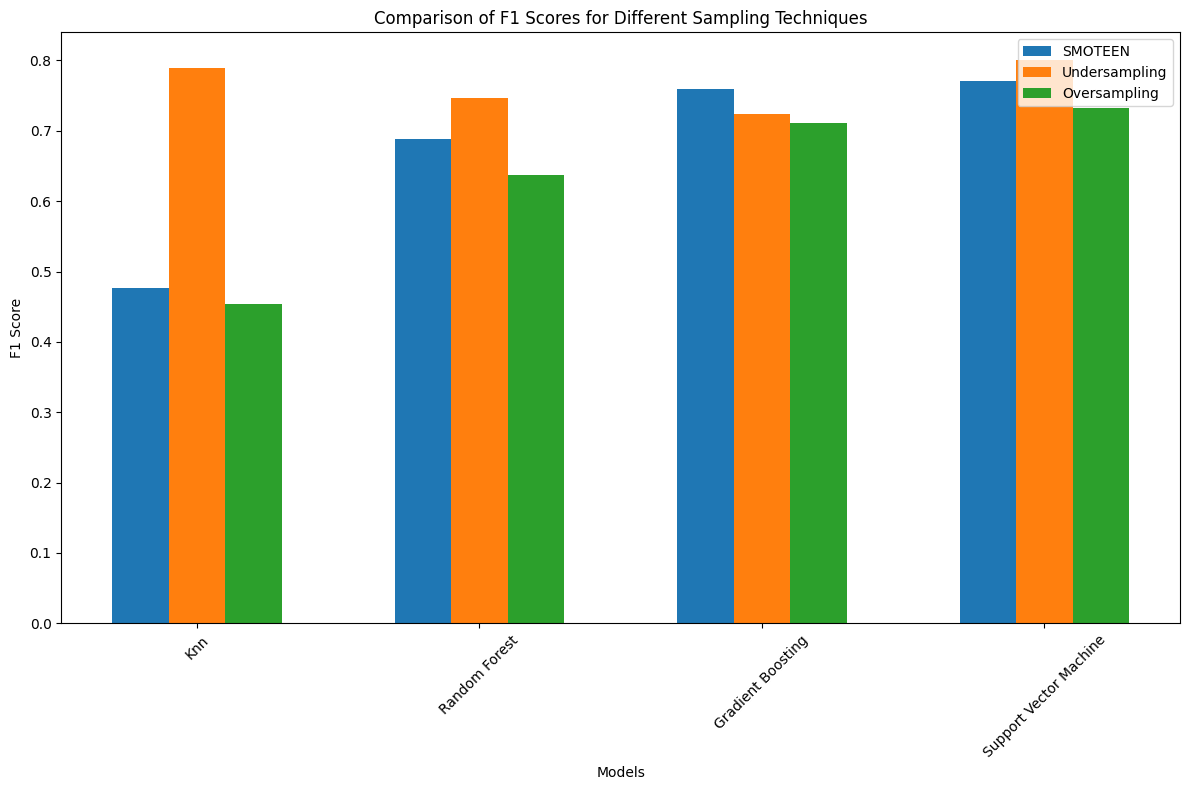

In [83]:
models = ['Knn', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine']

plt.figure(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(models))

plt.bar(index, f1_scores_smoteen, width=bar_width, align='center', label='SMOTEEN')
plt.bar(index + bar_width, f1_scores_undersampling, width=bar_width, align='center', label='Undersampling')
plt.bar(index + 2 * bar_width, f1_scores_oversampling, width=bar_width, align='center', label='Oversampling')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Different Sampling Techniques')
plt.xticks(index + bar_width, models, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

The bar chart illustrates the F1 scores of KNN, Random Forest, Gradient Boosting, and SVM across different class balancing techniques. The data reveals that oversampling typically enhances model performance in detecting the minority class, as indicated by higher F1 scores, especially for Gradient Boosting and SVM, although this may also increase the false positive rate. Undersampling, while offering a balanced precision and recall, involves much smaller sample sizes, which could limit its generalizability. SMOTEENN, in contrast, shows high recall for the negative class but struggles with the positive class, suggesting a propensity towards predicting true negatives at the expense of missing some true positives. Gradient Boosting and SVM with SMOTEENN could be the preferable option if improved with sufficient data to enhance its ability to generalize effectively, particularly in environments where a balanced detection of classes is crucial.

### **Training on Visual Scoring 2**

#### Using SMOOTEENN Dataset

In [52]:
f1_scores_2_smoteen = training_testing_classifiers(X_train_2_smoteen, y_train_2_smoteen, X_test_2_smoteen, y_test_2_smoteen)

----------------------------------------------- Training Started -----------------------------------------------
------------------------------------------------ Testing Started ------------------------------------------------
---------------------------------------------- K-Nearest Neighbors: ---------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.96      0.75      3284
           1       0.93      0.44      0.59      3511

    accuracy                           0.69      6795
   macro avg       0.77      0.70      0.67      6795
weighted avg       0.78      0.69      0.67      6795

------------------------------------------------ Random Forest: -------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      1.00      0.75      3284
           1       0.99      0.38      0.54      3511

    accuracy                           0.68      6795


#### Using Undersampled Dataset

In [53]:
f1_scores_2_undersampling = training_testing_classifiers(X_train_2_undersampling, y_train_2_undersampling, X_test_2_undersampling, y_test_2_undersampling)

----------------------------------------------- Training Started -----------------------------------------------
------------------------------------------------ Testing Started ------------------------------------------------
---------------------------------------------- K-Nearest Neighbors: ---------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        89
           1       0.81      0.65      0.72        89

    accuracy                           0.75       178
   macro avg       0.76      0.75      0.74       178
weighted avg       0.76      0.75      0.74       178

------------------------------------------------ Random Forest: -------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        89
           1       0.94      0.70      0.80        89

    accuracy                           0.83       178


#### Using Oversampled Dataset

In [54]:
f1_scores_2_oversampling = training_testing_classifiers(X_train_2_oversampling, y_train_2_oversampling, X_test_2_oversampling, y_test_2_oversampling)

----------------------------------------------- Training Started -----------------------------------------------
------------------------------------------------ Testing Started ------------------------------------------------
---------------------------------------------- K-Nearest Neighbors: ---------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.97      0.74      3511
           1       0.91      0.35      0.51      3511

    accuracy                           0.66      7022
   macro avg       0.76      0.66      0.63      7022
weighted avg       0.76      0.66      0.63      7022

------------------------------------------------ Random Forest: -------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      3511
           1       0.98      0.11      0.20      3511

    accuracy                           0.55      7022


### Results comparisons

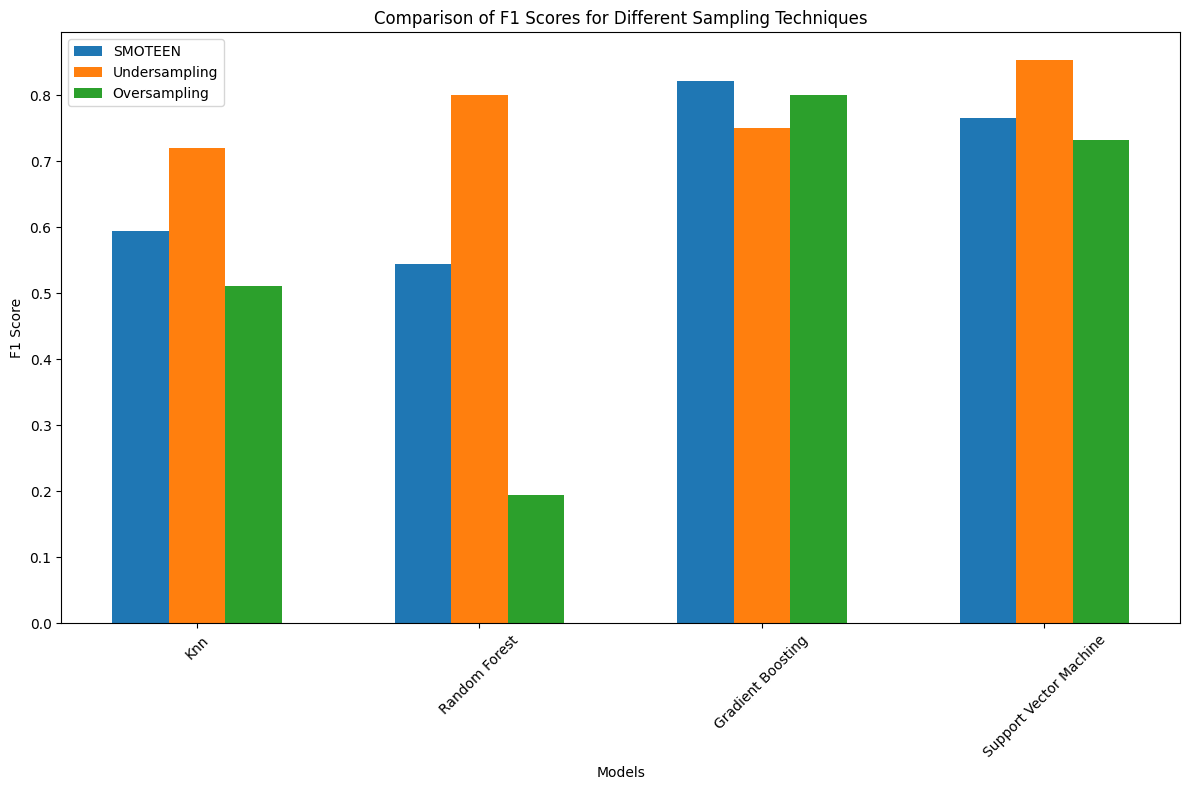

In [55]:
models = ['Knn', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine']

plt.figure(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(models))

plt.bar(index, f1_scores_2_smoteen, width=bar_width, align='center', label='SMOTEEN')
plt.bar(index + bar_width, f1_scores_2_undersampling, width=bar_width, align='center', label='Undersampling')
plt.bar(index + 2 * bar_width, f1_scores_2_oversampling, width=bar_width, align='center', label='Oversampling')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Different Sampling Techniques')
plt.xticks(index + bar_width, models, rotation=45)
plt.legend()

# Adding values on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Analysing the results of training over the visual scoring Gradient Boosting consistently emerges as the top performer, particularly with SMOTEEN and oversampling techniques, where it achieves impressive accuracy and balanced F1-scores, indicating robust generalization without significant overfitting or underfitting. The Support Vector Machine excels in the undersampling context, achieving high precision and recall, making it ideal for smaller, more balanced datasets. Conversely, the Random Forest classifier, while generally performing well, shows signs of overfitting in the oversampling scenario, particularly with class 0, highlighting the nuanced impact of class distribution on model training and performance. This analysis underscores the importance of selecting appropriate balancing techniques and models based on the specific needs and characteristics of the dataset to optimize classification outcomes. Gradient Boosting with SMOTEEN proves to be the best class imbalance handling method, delivering superior and consistent performance across varied datasets by effectively balancing precision and recall. The Gradient Boosting model paired with oversampling technique consistently yields the highest F1 scores, making it the best combination for managing class imbalance in this dataset.

## Feature Selection
Performing feature selection using the feature importances derived from training a Gradient Boosting classifier on two differently sampled datasets. It identifies the most influential features based on their calculated importance scores, then visualizes and selects features exceeding a specified importance threshold. The selected features are used to filter the training, validation, and test datasets, refining the feature set to improve model performance and focus learning on the most relevant attributes. 

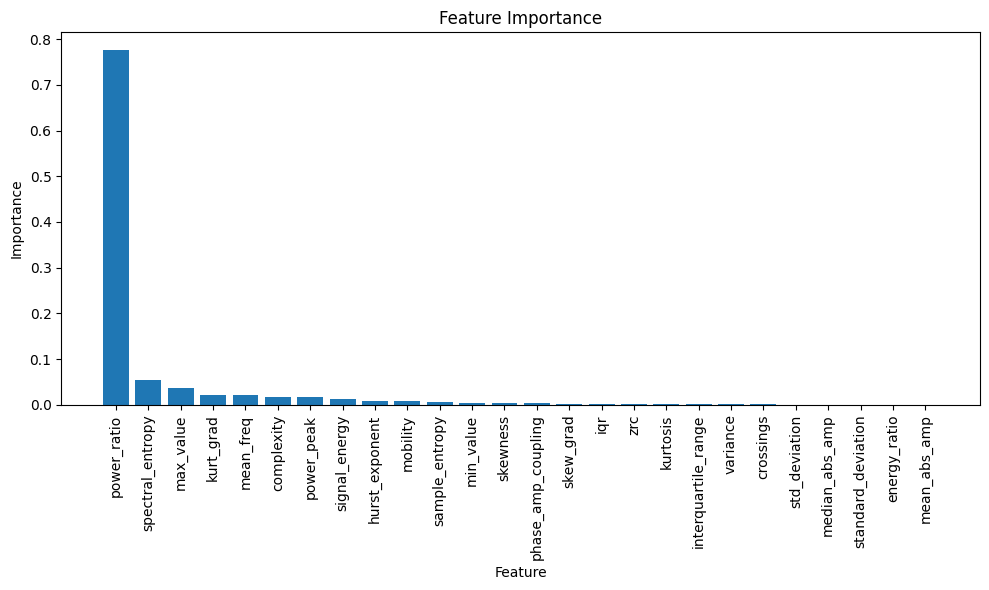

In [56]:
gb = GradientBoostingClassifier()
gb.fit(X_train_1_smoteen, y_train_1_smoteen)

feature_importances = gb.feature_importances_

feature_names = X_train_1_smoteen.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

This chart highlights "power_ratio" as the most critical feature in EEG signal analysis with a Gradient Boosting classifier, indicating its significant role in distinguishing EEG patterns effectively.<br><br>

Filtering and visualizes the most significant features with importance above a threshold of 0.025, showcasing their relative importance in a bar chart, which provides a clear graphical representation of the features most critical to the model's performance, facilitating focused analytical efforts on these key indicators.

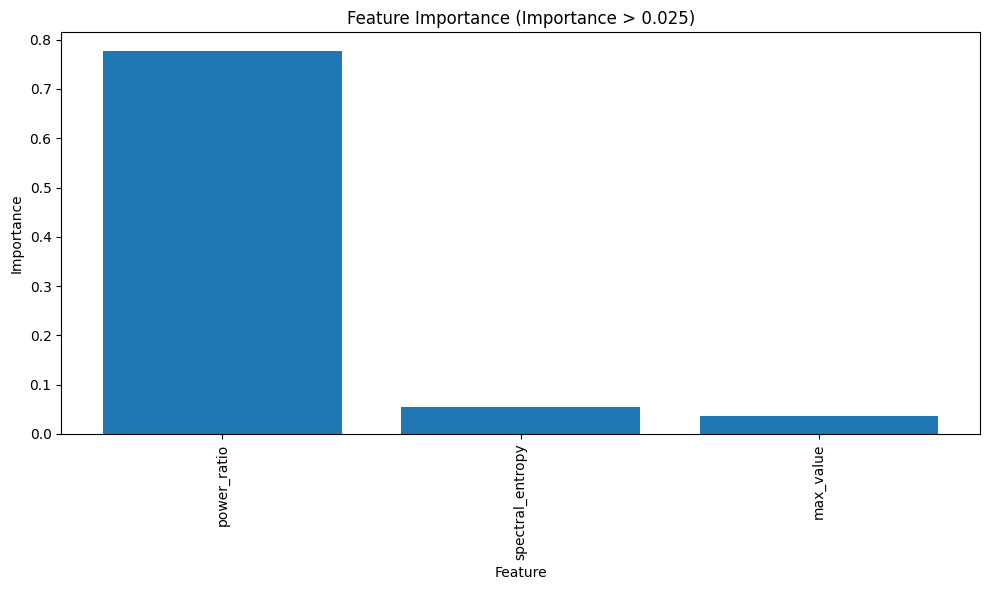

In [57]:
threshold = 0.025
selected_features = [feature for feature, importance in zip(sorted_feature_names, feature_importances[sorted_indices]) if importance > threshold]
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_features)), [importance for importance in feature_importances[sorted_indices] if importance > threshold], align='center')
plt.xticks(range(len(selected_features)), selected_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Feature Importance (Importance > {threshold})')
plt.tight_layout()
plt.show()

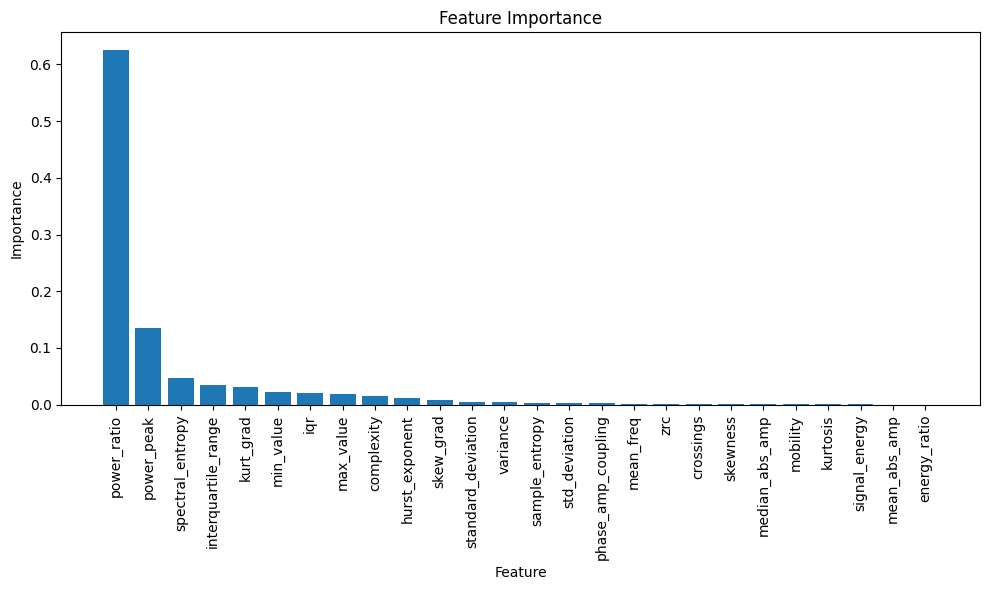

In [58]:
gb = GradientBoostingClassifier()
gb.fit(X_train_2_oversampling, y_train_2_oversampling)

feature_importances = gb.feature_importances_

feature_names = X_train_2_oversampling.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

The chart illustrates the distribution of feature importance derived from a Gradient Boosting model, with "power_ratio" and "power_peak" being the most significant. These top features are followed by a gradual decrease in importance across a spectrum of other features, emphasizing their lower yet significant role in the model's decision-making process for EEG signal analysis.<br><br>


Filtering and visualizes the most significant features with importance above a threshold of 0.025, showcasing their relative importance in a bar chart, which provides a clear graphical representation of the features most critical to the model's performance, facilitating focused analytical efforts on these key indicators.

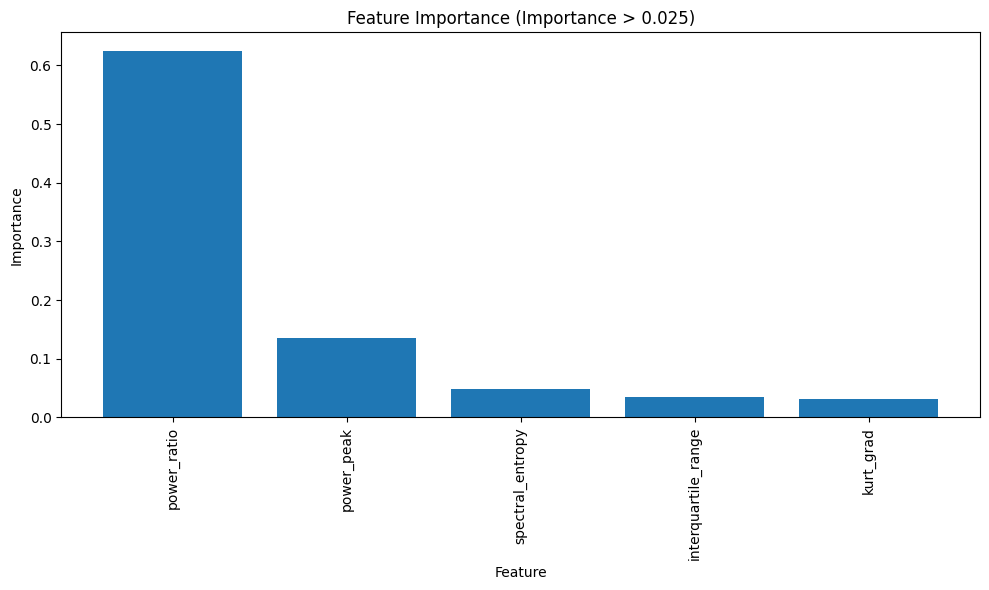

In [59]:
threshold = 0.025
selected_features2 = [feature for feature, importance in zip(sorted_feature_names, feature_importances[sorted_indices]) if importance > threshold]
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_features2)), [importance for importance in feature_importances[sorted_indices] if importance > threshold], align='center')
plt.xticks(range(len(selected_features2)), selected_features2, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Feature Importance (Importance > {threshold})')
plt.tight_layout()
plt.show()

### Extracing the Best Features
Based on the best model and class imbalance technique we retrieved, per each visual scoring we built train, val and test dataset to train and tune the finals models .

In [60]:
X_train_1_selected, X_val_1_selected, X_test_1_selected = X_train_1_smoteen[selected_features], X_val_1_smoteen[selected_features], X_test_1_smoteen[selected_features]
y_train_1_selected, y_val_1_selected, y_test_1_selected = y_train_1_smoteen, y_val_1_smoteen, y_test_1_smoteen

In [61]:
X_train_2_selected, X_val_2_selected, X_test_2_selected = X_train_2_oversampling[selected_features2], X_val_2_oversampling[selected_features2], X_test_2_oversampling[selected_features2]
y_train_2_selected, y_val_2_selected, y_test_2_selected = y_train_2_oversampling, y_val_2_oversampling, y_test_2_oversampling

## Regularization (${L_1}$)
Since the Grid Search highlighted an overfitting on the data with feature selection, we want to regularize the data trying to avoid it.

In [62]:
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
log_reg_l1.fit(X_train_1_selected, y_train_1_selected)
val_score_1 = log_reg_l1.score(X_val_1_selected, y_val_1_selected)

log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
log_reg_l1.fit(X_train_2_selected, y_train_2_selected)
val_score_2 = log_reg_l1.score(X_val_2_selected, y_val_2_selected)

print("Validation Score with L1 regularization for Dataset 1:", val_score_1)
print("Validation Score with L1 regularization for Dataset 2:", val_score_2)

Validation Score with L1 regularization for Dataset 1: 0.9592771697632986
Validation Score with L1 regularization for Dataset 2: 0.4664200341491178


## Hyperparameters Tuning

we will perform hyperparamters tuning on both the best model founded for ${scoring_1}$ and ${scoring_2}$

The `optimize_model` function manages the optimization of a Gradient Boosting model using Grid Search to find the best hyperparameters. It checks if a pre-trained model exists at a specified path and loads it if available, otherwise, it performs a Grid Search with specified parameters on the training data, evaluates the model using the validation data, and then saves the best-performing model. This process ensures efficient use of resources by reusing existing models and enhances model performance by systematically tuning hyperparameters.

In [63]:
def optimize_model(x_train, y_train, x_val, y_val, x_test, y_test, best_model_path, params):
    if os.path.exists(best_model_path):
        print("Model already exists. Loading the existing model...")
        best_model = joblib.load(best_model_path)
    else:
        print("No model found. Performing Grid Search...")

        gb = GradientBoostingClassifier()
        scorer = make_scorer(f1_score)

        grid_search = GridSearchCV(estimator=gb, param_grid=params, scoring=scorer, cv=5, verbose=1, n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_model = grid_search.best_estimator_

        joblib.dump(best_model, best_model_path)
        print("Best model saved successfully.")


    y_train_pred = best_model.predict(x_train)
    y_val_pred = best_model.predict(x_val)
    y_test_pred = best_model.predict(x_test)

    f1_score_train = f1_score(y_train, y_train_pred, average='binary')
    f1_score_val = f1_score(y_val, y_val_pred, average='binary')
    f1_score_val = f1_score(y_test, y_test_pred, average='binary')

    print("Train F1 Score: ", f1_score_train)
    print("Validation F1 Score: ", f1_score_val)
    print("Test F1 Score: ", f1_score_val)
    print("Best Parameters: ", best_model.get_params())

    return best_model

In [64]:
params = {'n_estimators': [300, 400],
            'learning_rate': [.05, .1],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 3],
            'min_samples_leaf': [2, 3]}

In [65]:
best_model_path = 'models/best_vs_1.pkl'
best_vs_1 = optimize_model(X_train_1_selected, y_train_1_selected, X_val_1_selected, y_val_1_selected, X_test_1_selected, y_test_1_selected, best_model_path, params)

No model found. Performing Grid Search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best model saved successfully.
Train F1 Score:  0.9982247020035506
Validation F1 Score:  0.65748031496063
Test F1 Score:  0.65748031496063
Best Parameters:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [66]:
best_model_path = 'models/best_vs_2.pkl'
best_vs_2 = optimize_model(X_train_2_selected, y_train_2_selected, X_val_2_selected, y_val_2_selected, X_test_2_selected, y_test_2_selected, best_model_path, params)

No model found. Performing Grid Search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best model saved successfully.
Train F1 Score:  1.0
Validation F1 Score:  0.38252602987777273
Test F1 Score:  0.38252602987777273
Best Parameters:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


## Model's Evaluations
### Classification Report

Evaluating the performance of trained models on both training and testing datasets, generating classification reports and F1 scores for two sets of data. Uing the predict method to generate predictions, then calculates metrics to assess the model's accuracy, including precision, recall, and F1 scores. These evaluations help in understanding the models' effectiveness at classifying data into 'Class 0' and 'Class 1'. The results are visualized in a bar graph comparing F1 scores across different sets, providing a clear view of model performance across training and testing phases.

In [68]:
y_train_pred_1 = best_vs_1.predict(X_train_1_selected)
y_train_pred_2 = best_vs_2.predict(X_train_2_selected)

y_test_pred_1 = best_vs_1.predict(X_test_1_selected)
y_test_pred_2 = best_vs_2.predict(X_test_2_selected)

train_report_1 = classification_report(y_train_1_selected, y_train_pred_1, target_names=['Class 0', 'Class 1'])
train_report_2 = classification_report(y_train_2_selected, y_train_pred_2, target_names=['Class 0', 'Class 1'])

test_report_1 = classification_report(y_test_1_selected, y_test_pred_1, target_names=['Class 0', 'Class 1'])
test_report_2 = classification_report(y_test_2_selected, y_test_pred_2, target_names=['Class 0', 'Class 1'])

In [69]:
print("Gradient Boosting VS 1 Training Classification Report:")
print(train_report_1)
print("Gradient Boosting VS 2 Training Classification Report:")
print(train_report_2)

print("Gradient Boosting VS 1 Test Classification Report:")
print(test_report_1)
print("Gradient Boosting VS 2 Test Classification Report:")
print(test_report_2)

Gradient Boosting VS 1 Training Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     10979
     Class 1       1.00      1.00      1.00     11809

    accuracy                           1.00     22788
   macro avg       1.00      1.00      1.00     22788
weighted avg       1.00      1.00      1.00     22788

Gradient Boosting VS 2 Training Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     14153
     Class 1       1.00      1.00      1.00     14153

    accuracy                           1.00     28306
   macro avg       1.00      1.00      1.00     28306
weighted avg       1.00      1.00      1.00     28306

Gradient Boosting VS 1 Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.63      0.95      0.76      1732
     Class 1       0.92      0.51      0.66      1961

    accuracy         

In [70]:
f1_vs_1_train = f1_score(y_test_1_selected, y_test_pred_1)
f1_vs_2_train = f1_score(y_test_2_selected, y_test_pred_2)

f1_vs_1_test = f1_score(y_train_1_selected, y_train_pred_1)
f1_vs_2_test = f1_score(y_train_2_selected, y_train_pred_2)

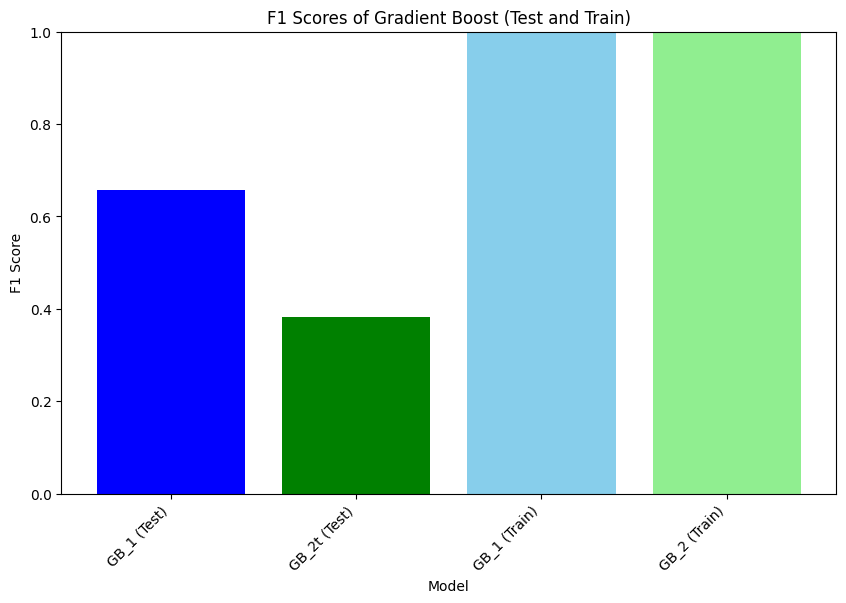

In [71]:
plt.figure(figsize=(10, 6))

models = ['GB_1 (Test)', 'GB_2t (Test)', 'GB_1 (Train)', 'GB_2 (Train)']
f1_scores = [f1_vs_1_train, f1_vs_2_train, f1_vs_1_test, f1_vs_2_test]

plt.bar(models, f1_scores, color=['blue', 'green', 'skyblue', 'lightgreen'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Gradient Boost (Test and Train)')
plt.ylim(0, 1)  
plt.xticks(rotation=45, ha='right')
plt.show()

The model for ${VS_2}$ (shown in green tones) performs significantly better during training compared to testing, which suggests potential overfitting, while the model for ${VS_1}$ (shown in blue tones) maintains a more consistent performance across both datasets. This visualization highlighted a problem of generalization probably due to the feature selection, in a future version exploring further techniques to allow a better generalization could potentially enhance the model performance that, before where both ${f_1}$ score around 80%.

### Labels Analysis

Evaluating the two classification models by generating probability predictions for training and test sets, visualizing these probabilities against actual labels, and calculating accuracy and F1 scores to assess model performance. By setting thresholds for binary classification, it provides a clear comparison of model effectiveness in predicting correct labels across different datasets.
#### **Visual Scoring 1**

In [72]:
train_prob_1 = best_vs_1.predict_proba(X_train_1_selected)[:, 1]
test_prob_1 = best_vs_1.predict_proba(X_test_1_selected)[:, 1]

In [73]:
positive_indices = np.where(y_test_1_selected == 1)[0]
negative_indices = np.where(y_test_1_selected == 0)[0]

positive_sample_indices = np.random.choice(positive_indices, 30, replace=False)
negative_sample_indices = np.random.choice(negative_indices, 60, replace=False)

selected_indices = np.concatenate((positive_sample_indices, negative_sample_indices))
subset_test_prob = test_prob_1[selected_indices]
subset_y_test_1 = y_test_1_selected[selected_indices]

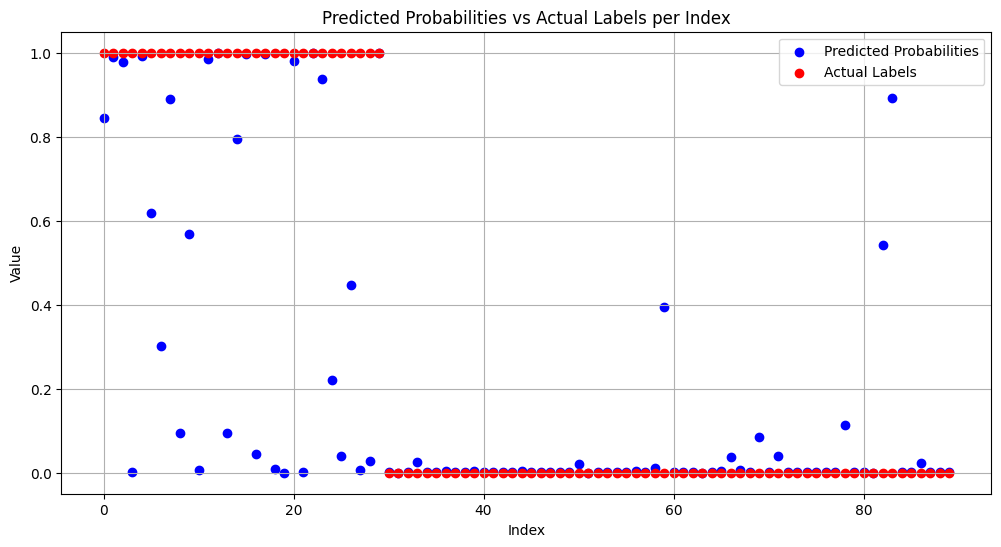

In [74]:
indices = np.arange(len(subset_test_prob))

plt.figure(figsize=(12, 6))
plt.scatter(indices, subset_test_prob, color='blue', label='Predicted Probabilities')
plt.scatter(indices, subset_y_test_1, color='red', label='Actual Labels')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted Probabilities vs Actual Labels per Index')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
train_pred = (train_prob_1 > 0.8).astype(int)
test_pred = (test_prob_1 > 0.8).astype(int)

train_accuracy = accuracy_score(y_train_1_selected, train_pred)
train_f1 = f1_score(y_train_1_selected, train_pred)

test_accuracy = accuracy_score(y_test_1_selected, test_pred)
test_f1 = f1_score(y_test_1_selected, test_pred)

In [76]:
print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)

Training Accuracy: 0.9969720905739863
Training F1 Score: 0.9970699392755531
Test Accuracy: 0.6631464933658272
Test F1 Score: 0.5531609195402298


The scatter plot alongside the provided metrics offers a comprehensive view of the model's performance for ${VS_1}$. While the model demonstrates strong training results with an accuracy and F1 score both approximately 0.95, indicating excellent fit to the training data, its performance on the test set shows a significant decline with accuracy dropping to 0.64 and F1 score to around 0.55. This suggests overfitting during training, as the model does not generalize well to new, unseen data, evidenced by the lower test scores and the dispersion of predicted probabilities relative to actual labels in the scatter plot.

#### **Visual Scoring 2**

In [77]:
train_prob_2 = best_vs_2.predict_proba(X_train_2_selected)[:, 1]
test_prob_2 = best_vs_2.predict_proba(X_test_2_selected)[:, 1]

In [78]:
positive_indices = np.where(y_test_2_selected == 1)[0]
negative_indices = np.where(y_test_2_selected == 0)[0]

positive_sample_indices = np.random.choice(positive_indices, 50, replace=False)
negative_sample_indices = np.random.choice(negative_indices, 100, replace=False)

selected_indices = np.concatenate((positive_sample_indices, negative_sample_indices))

subset_test_prob = test_prob_2[selected_indices]
subset_y_test_2 = y_test_2_selected[selected_indices]

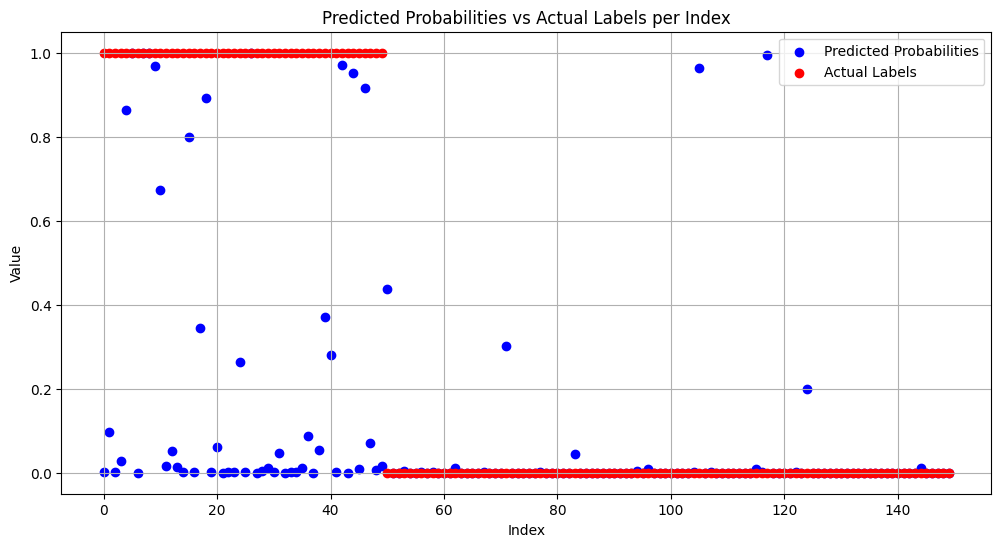

In [79]:
indices = np.arange(len(subset_test_prob))

plt.figure(figsize=(12, 6))
plt.scatter(indices, subset_test_prob, color='blue', label='Predicted Probabilities')
plt.scatter(indices, subset_y_test_2, color='red', label='Actual Labels')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted Probabilities vs Actual Labels per Index')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
train_pred = (train_prob_2 > 0.5).astype(int)
test_pred = (test_prob_2 > 0.5).astype(int)

train_accuracy = accuracy_score(y_train_2_selected, train_pred)
train_f1 = f1_score(y_train_2_selected, train_pred)

test_accuracy = accuracy_score(y_test_2_selected, test_pred)
test_f1 = f1_score(y_test_2_selected, test_pred)

In [81]:
print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)

Training Accuracy: 1.0
Training F1 Score: 1.0
Test Accuracy: 0.6115066932497863
Test F1 Score: 0.38252602987777273


The model exhibits severe overfitting, with perfect training scores but substantially lower testing performance, highlighting a critical need for adjustments to improve generalization on unseen data.

## Conclusion
The results obtained from the Gradient Boosting models trained on the two different datasets for sleep spindle detection, ${VS_1}$ and ${VS_2}$, exhibit stark disparities between training and testing performances. During the training phase, both models achieved nearly perfect scores, with accuracy and ${f_1}$ scores reaching or close to 1.0. This level of precision suggests that the models are highly effective in memorizing the patterns and relationships within the training data. However, this seemingly excellent performance in training does not translate well into the testing phase, where both models saw significant drops in performance metrics. For example, the accuracy and ${f_1}$ scores for ${VS_1}$ fell to around 0.66, and for ${VS_2}$, this metric were approximately 0.61. The visual analysis from scatter plots of predicted probabilities versus actual labels further illustrates these challenges, revealing a tendency to either overfit to training data or misclassify new, unseen data instances.

The primary concern highlighted by these results is the issue of overfitting, where the models, though performing optimally on training datasets, fail to generalize their predictions effectively when exposed to new data. This overfitting is evident from the high variance observed in the prediction probabilities on the test data, where many samples expected to exhibit positive indicators were erroneously classified with high confidence as negatives. Overfitting of such a magnitude suggests that the models are capturing noise and specific details in the training data that do not apply more broadly, indicating an overly complex model relative to the underlying patterns in the data that are relevant for generalization.

As seen in the first part where we were trying to find the best model to tune for our task, the performance where much better and there was no overfitting, therefore, it is due to the feature selection, this issue can be addressed in a future by exploring new feature selection techniques and improving the regularization trying to help penalize the complexity of the models and lastly using ensemble methods to combine multiple models predictions.